# Predicting Ride Price using Linear Regression
There are 7 parts in this notebook.

0. Preprocess the dataframe
1. Training on plaintext data
2. Evaluate model on plaintext data
3. Quantize the model
4. Compile the model to the equivalent FHE circuit
5. Evaluate the FHE model on encrypted data
6. MAE and R^2 measurement

In [3]:
# import required packages
import time
import numpy as np
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression
import pandas as pd
import matplotlib.pyplot as plt

/opt/miniconda3/envs/concrete-arm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# import dataset as panda's dataframe
house_dataset = pd.read_csv("./data/house_dataset.csv")

print(house_dataset)

        Id MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape  \
0        1         60       RL          65    8450   Pave   NaN      Reg   
1        2         20       RL          80    9600   Pave   NaN      Reg   
2        3         60       RL          68   11250   Pave   NaN      IR1   
3        4         70       RL          60    9550   Pave   NaN      IR1   
4        5         60       RL          84   14260   Pave   NaN      IR1   
...    ...        ...      ...         ...     ...    ...   ...      ...   
2915  2915        160       RM          21    1936   Pave   NaN      Reg   
2916  2916        160       RM          21    1894   Pave   NaN      Reg   
2917  2917         20       RL         160   20000   Pave   NaN      Reg   
2918  2918         85       RL          62   10441   Pave   NaN      Reg   
2919  2919         60       RL          74    9627   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0        

## 0. Preprocess the dataframe

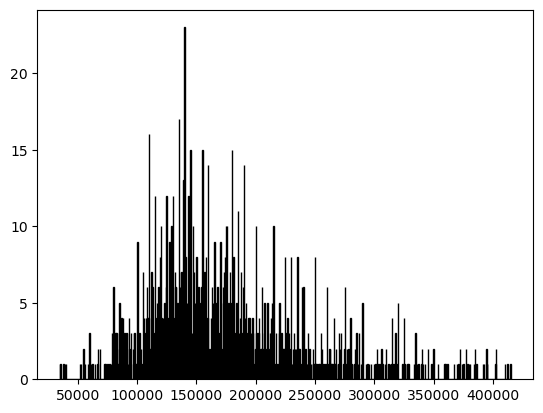

In [5]:
target = house_dataset.pop('SalePrice')
# for key in ['tip', 'start_longitude', 'end_longitude', 'start_latitude', 'end_latitude', 'airport']:
#   house_dataset.pop(key)
# house_dataset['distance'] = round(100*house_dataset['distance'])
mean = target.mean()
std = target.std()
house_dataset = house_dataset[target < mean + 3*std]
target = target[target < mean + 3*std]

# print(house_dataset)
plt.hist(target, bins=1000,edgecolor='black')
plt.show()

In [7]:
# split dataset into 80% training data and 20% testing data
# house_dataset = np.array(house_dataset).astype(float)
# target = np.array(round(target*100))
X_train, X_test, y_train, y_test = train_test_split(
    house_dataset, target, test_size=0.4, random_state=42
)

## 1. Training on plaintext data

In [8]:
# train LinearRegression model on the clear
sklearn_lr = SklearnLinearRegression()
sklearn_lr.fit(X_train, y_train)

ValueError: could not convert string to float: 'FV'

## 2. Evaluate model on plaintext data

In [19]:
time_begin = time.time()
y_pred = sklearn_lr.predict(X_test)
execution_time_on_plaintext = (time.time() - time_begin) / len(X_test)
print(f"Model evaluation time in the clear: {execution_time_on_plaintext:.8f} seconds per sample")

# Compute MAE
mae_clear = mean_absolute_error(y_test, y_pred)/100
print('sklearn model MAE in the clear : ', mae_clear)

# Compute the R2 scores
sklearn_r2_score = r2_score(y_test, y_pred)
print("sklearn model r2 score in the clear: ", sklearn_r2_score)


Model evaluation time in the clear: 0.00000002 seconds per sample
sklearn model MAE in the clear :  1.5775081052201871
sklearn model r2 score in the clear:  0.8950561066973235


In [7]:
print('few sample test')
for i in range(20):
  print('pred:', sklearn_lr.predict(X_test[i:i+1])/100, 'true:', y_test[i:i+1]/100)

few sample test
pred: [13.27609804] true: [14.76]
pred: [14.14026315] true: [14.3]
pred: [7.06438021] true: [6.8]
pred: [15.15865544] true: [15.3]
pred: [8.80598941] true: [9.75]
pred: [5.40917101] true: [4.8]
pred: [26.17589583] true: [25.56]
pred: [14.88592184] true: [15.96]
pred: [8.82468904] true: [8.8]
pred: [31.60240385] true: [32.8]
pred: [31.18730702] true: [3.8]
pred: [18.08124983] true: [20.3]
pred: [8.96142237] true: [10.4]
pred: [6.04422923] true: [6.3]
pred: [7.9390099] true: [8.8]
pred: [9.75825371] true: [9.96]
pred: [8.17509078] true: [6.8]
pred: [10.65121272] true: [10.3]
pred: [13.97094047] true: [12.95]
pred: [10.53035937] true: [10.8]


## 3. Quantize the model

In [10]:
# Quantize the model (convert all the floating point numbers of weights and biases (32 bits) to integers (8 bits))
# set the quantization parameter on input as 8 bits
concrete_lr = ConcreteLinearRegression(n_bits=8)

# train the concrete linear regression model on clear data
concrete_lr.fit(X_train, y_train)

# Now, we can test our Concrete ML model on the clear test data
y_pred_q = concrete_lr.predict(X_test)

# Compute the msa for quantized model
mae_q = mean_absolute_error(y_test, y_pred_q)/100
print('quantized model MAE: ', mae_q)

# Compute the R2 scores
quantized_r2_score = r2_score(y_test, y_pred_q)
print('quantized model R^2 score: ', quantized_r2_score)

quantized model MAE:  1.608154731883134
quantized model R^2 score:  0.8919973140201058


## 4. Compile the model to the equivalent FHE circuit

In [11]:
# Compile the quantized model in to FHE circuit and run inference on it
# You have to provide the training dataset in order to compile the quantized model to equivalent FHE circuit
time_begin = time.time()
fhe_circuit = concrete_lr.compile(X_train)
print(f"Generating a key for a {fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")
print(f"Compilation time: {time.time() - time_begin:.4f} seconds")

# Compiler returns the circuit, which can be used to generated a secrete key and evaluation key
# secrete key: used for encryption and decryption. only accesible to the client
# evaluation key: used to evaluate the cirucit on encypted data. anyone can access it
print(f"Generating a key for a {fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")

time_begin = time.time()
fhe_circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.4f} seconds")

Generating a key for a 18-bit circuit
Compilation time: 37.0096 seconds
Generating a key for a 18-bit circuit
Key generation time: 0.0016 seconds


## 5. Evaluate the FHE model on encrypted data

In [14]:
# Evaluate the FHE-version of the model on encrypted data
time_begin = time.time()

decrypted_prediction_list = []

for i, input in enumerate(X_test):
	quantized_input = concrete_lr.quantize_input([np.array(input)])

	encrypted_input = fhe_circuit.encrypt(quantized_input)

	encrypted_prediction = fhe_circuit.run(encrypted_input)

	decrypted_prediction = concrete_lr.dequantize_output(fhe_circuit.decrypt(encrypted_prediction))

	decrypted_prediction_list.append(decrypted_prediction[0][0])



execution_time_on_ciphertext = (time.time() - time_begin)/len(X_test)

# Measure MSE of FHE version of the model
mae_fhe = mean_absolute_error(y_test, decrypted_prediction_list)/100

# Measure R2 score of FHE version of the model
fhe_r2_score = r2_score(y_test, decrypted_prediction_list)

print(f"Execution time: {execution_time_on_ciphertext:.8f} seconds per sample")
print(f"which is {(execution_time_on_ciphertext / execution_time_on_plaintext):.2f} times slower than prediction on the plaintext data")

Execution time: 0.00250525 seconds per sample
which is 15521.97 times slower than prediction on the plaintext data


## 6. MAE and R^2 Score Measurement

In [17]:
print("MAE:")
print(f"- scikit-learn (clear): {mae_clear:.4f}")
print(f"- Concrete ML (quantized model on plaintext): {mae_q:.4f}")
print(f"- Concrete ML (FHE model on ciphertext): {mae_fhe:.4f}\n")

print("R^2 scores:")
print(f"- scikit-learn (clear): {sklearn_r2_score:.4f}")
print(f"- Concrete ML (quantized model on plaintext): {quantized_r2_score:.4f}")
print(f"- Concrete ML (FHE model on ciphertext): {fhe_r2_score:.4f} \n")

#Measure the error of the FHE quantized model with respect to the clear float model
score_difference = abs(quantized_r2_score - sklearn_r2_score) * 100 / sklearn_r2_score
print(
    "Relative R^2 score difference between scikit-learn (clear) and quntized model (clear):",
    f"{score_difference:.2f}%",
)

#Measure the error of the FHE quantized model with respect to the clear scikit-learn float model
concrete_score_difference = abs(fhe_r2_score - quantized_r2_score) * 100 / quantized_r2_score
print(
    "Relative R^2 score difference between quantized model (clear) vs. Concrete ML (FHE):",
    f"{concrete_score_difference:.2f}%",
)



MAE:
- scikit-learn (clear): 1.5775
- Concrete ML (quantized model on plaintext): 1.6082
- Concrete ML (FHE model on ciphertext): 1.6082

R^2 scores:
- scikit-learn (clear): 0.8951
- Concrete ML (quantized model on plaintext): 0.8920
- Concrete ML (FHE model on ciphertext): 0.8920 

Relative R^2 score difference between scikit-learn (clear) and quntized model (clear): 0.34%
Relative R^2 score difference between quantized model (clear) vs. Concrete ML (FHE): 0.00%
